In [1]:
import os
from math import pi
import numpy as np
import random
import itertools
import scipy.optimize as opt
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms import utils

In [2]:
shots = 100
epsilon_parameters=0.1 # scaling factor for initial random parameters (chosen between 0 to 2pi otherwise)

n_qubits = 3
n_bases = 27
depth = 10

max_iter = 1000

param_name = "theta"

# save checkpoints in case the connection to qpu breaks
# useful for running on real qpu, but not necessary for local simulation
have_checkpoints = False
checkpoint_path = None

# seed = 1000
trial = 0

bw_list = [0.1]
bw_coeff_list = [10.]

In [3]:
rng = np.random.default_rng()

In [4]:
# backend = AerSimulator()
# sampler = Sampler.from_backend(backend)
# pm = generate_preset_pass_manager(backend=backend)

simulator_ideal = AerSimulator()
sampler_ideal = Sampler.from_backend(simulator_ideal)
pm_ideal = generate_preset_pass_manager(backend=simulator_ideal, optimization_level=1)

sampler = sampler_ideal
pm = pm_ideal

In [5]:
def create_ghz_state(n):
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n - 1):
        qc.cx(i, i + 1)
    return qc

def get_circ_for_basis(qc: QuantumCircuit, basis: str):
    circ = qc.copy()
    for i, s in enumerate(basis[::-1]): # here, I am using the same endian convention as qiskit, where the last bit represent the first qubit
        if s == 'Z':
            pass
        elif s == 'X':
            circ.ry(-pi/2, i)
        elif s == 'Y':
            circ.rx(pi/2, i)
        else:
            raise ValueError(f"{s} is invalid basis")

    circ.measure_all()

    return circ

def get_isa_circ_list_for_bases(qc: QuantumCircuit, basis_list, pass_manager):
    circ_list = [get_circ_for_basis(qc, basis) for basis in basis_list]
    isa_circ_list = pass_manager.run(circ_list)
    return isa_circ_list


def measure_isa_circ_list_fs(isa_circ_list, basis_list, shots=shots):
    sampler = Sampler()
    result_list = sampler.run(isa_circ_list, shots=shots).result()
    counts_list = [result.data.meas.get_counts() for result in result_list]
    results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    return results_dic


def get_basis_list(n_bases,n_qubits):
    bases = ["X", "Y", "Z"]
    basis_list = ["".join(p) for p in itertools.product(bases, repeat=n_qubits)]
    culled_basis_list = random.sample(basis_list, n_bases)
    return culled_basis_list




# def measure_circ_for_all_basis(qc, basis_list, shots=total_shots, sampler=None):
#     results_dic = {}
#     qc_list = [get_circ_for_basis(qc, basis, simulator) for basis in basis_list]
#     job = simulator.run(qc_list, shots=shots)
#     result = job.result()
#     counts_list = result.get_counts()
#     results_dic = {basis:counts for (basis, counts) in zip(basis_list, counts_list)}
    
#     return results_dic

In [6]:
basis_list = get_basis_list(n_bases, n_qubits)
ghz_circ = create_ghz_state(n_qubits)
ghz_circ_isa_list = get_isa_circ_list_for_bases(ghz_circ, basis_list, pm_ideal)
GHZ_measurement = measure_isa_circ_list_fs(ghz_circ_isa_list, basis_list, shots=shots)

In [7]:
GHZ_measurement

{'YYY': {'000': 11,
  '011': 20,
  '001': 12,
  '110': 14,
  '010': 14,
  '101': 5,
  '100': 10,
  '111': 14},
 'YYX': {'001': 18, '100': 24, '111': 27, '010': 31},
 'ZZX': {'000': 26, '001': 20, '111': 29, '110': 25},
 'XYX': {'110': 15,
  '011': 12,
  '111': 9,
  '101': 16,
  '100': 12,
  '001': 17,
  '010': 11,
  '000': 8},
 'YZZ': {'100': 22, '000': 31, '011': 18, '111': 29},
 'XXZ': {'101': 9,
  '000': 11,
  '011': 14,
  '010': 18,
  '100': 12,
  '001': 12,
  '111': 7,
  '110': 17},
 'YXX': {'110': 11,
  '111': 19,
  '101': 13,
  '100': 8,
  '001': 17,
  '010': 8,
  '011': 12,
  '000': 12},
 'ZXY': {'110': 14,
  '000': 12,
  '010': 16,
  '101': 12,
  '100': 14,
  '001': 8,
  '011': 12,
  '111': 12},
 'ZYX': {'000': 13,
  '111': 16,
  '100': 17,
  '011': 18,
  '101': 7,
  '001': 7,
  '110': 14,
  '010': 8},
 'XYY': {'001': 26, '100': 27, '010': 25, '111': 22},
 'XXY': {'010': 12,
  '111': 13,
  '110': 12,
  '101': 19,
  '001': 11,
  '100': 7,
  '000': 14,
  '011': 12},
 'ZZY': {'11

In [8]:
print(basis_list)

['YYY', 'YYX', 'ZZX', 'XYX', 'YZZ', 'XXZ', 'YXX', 'ZXY', 'ZYX', 'XYY', 'XXY', 'ZZY', 'YZX', 'XZX', 'YXZ', 'ZZZ', 'YXY', 'XZZ', 'ZXX', 'XZY', 'ZYY', 'YZY', 'XYZ', 'ZYZ', 'YYZ', 'XXX', 'ZXZ']


In [9]:
print(GHZ_measurement)

{'YYY': {'000': 11, '011': 20, '001': 12, '110': 14, '010': 14, '101': 5, '100': 10, '111': 14}, 'YYX': {'001': 18, '100': 24, '111': 27, '010': 31}, 'ZZX': {'000': 26, '001': 20, '111': 29, '110': 25}, 'XYX': {'110': 15, '011': 12, '111': 9, '101': 16, '100': 12, '001': 17, '010': 11, '000': 8}, 'YZZ': {'100': 22, '000': 31, '011': 18, '111': 29}, 'XXZ': {'101': 9, '000': 11, '011': 14, '010': 18, '100': 12, '001': 12, '111': 7, '110': 17}, 'YXX': {'110': 11, '111': 19, '101': 13, '100': 8, '001': 17, '010': 8, '011': 12, '000': 12}, 'ZXY': {'110': 14, '000': 12, '010': 16, '101': 12, '100': 14, '001': 8, '011': 12, '111': 12}, 'ZYX': {'000': 13, '111': 16, '100': 17, '011': 18, '101': 7, '001': 7, '110': 14, '010': 8}, 'XYY': {'001': 26, '100': 27, '010': 25, '111': 22}, 'XXY': {'010': 12, '111': 13, '110': 12, '101': 19, '001': 11, '100': 7, '000': 14, '011': 12}, 'ZZY': {'110': 25, '111': 27, '000': 21, '001': 27}, 'YZX': {'101': 14, '010': 9, '110': 14, '011': 20, '001': 10, '000'

In [10]:
def initialize_theta_random(circ_depth=10, num_qbits=3):
    """
    Initialize the theta parameter vector
    :param circ_depth: int, number of parameterized layers in circuit
    :param num_qbits: int, number of qbits
    :return: np.array, values of theta
    """

    theta = rng.random(size=(circ_depth, num_qbits))
    theta = 2*pi*epsilon_parameters*theta
    return theta

In [11]:
def construct_variational_circ_ansatz(num_qbits, circ_depth, param_name = param_name):
    """
    Generate a parameterized variational quantum circuit
    
    """

    num_parameters = num_qbits * circ_depth
    theta_vec = ParameterVector(param_name, length=num_parameters)
    var_circ = QuantumCircuit(num_qbits)


    for layer in range(circ_depth - 1):
        # Compute if layer is odd or even to apply rx or ry gate to circuit
        is_odd_step = (layer + 1) % 2

        for qbit in range(num_qbits):
            if is_odd_step:
                var_circ.rx(theta_vec[layer * num_qbits + qbit], qbit)
            else:
                var_circ.ry(theta_vec[layer * num_qbits + qbit], qbit)

        # Apply CX gates
        for qbit in range((1-is_odd_step), num_qbits-1, 2):
            # isOddStep may subtract 1 if True, to correctly apply cx gate location
            var_circ.cx(qbit , qbit + 1)
            var_circ.barrier() # for visualization only

    for qbit in range(num_qbits):  # bonus layer at the end only has rx gates and no cx
        var_circ.rx(theta_vec[(circ_depth - 1) * num_qbits + qbit], qbit)

    return var_circ, theta_vec


In [12]:
ansatz, param_vec = construct_variational_circ_ansatz(n_qubits, depth, param_name=param_name)

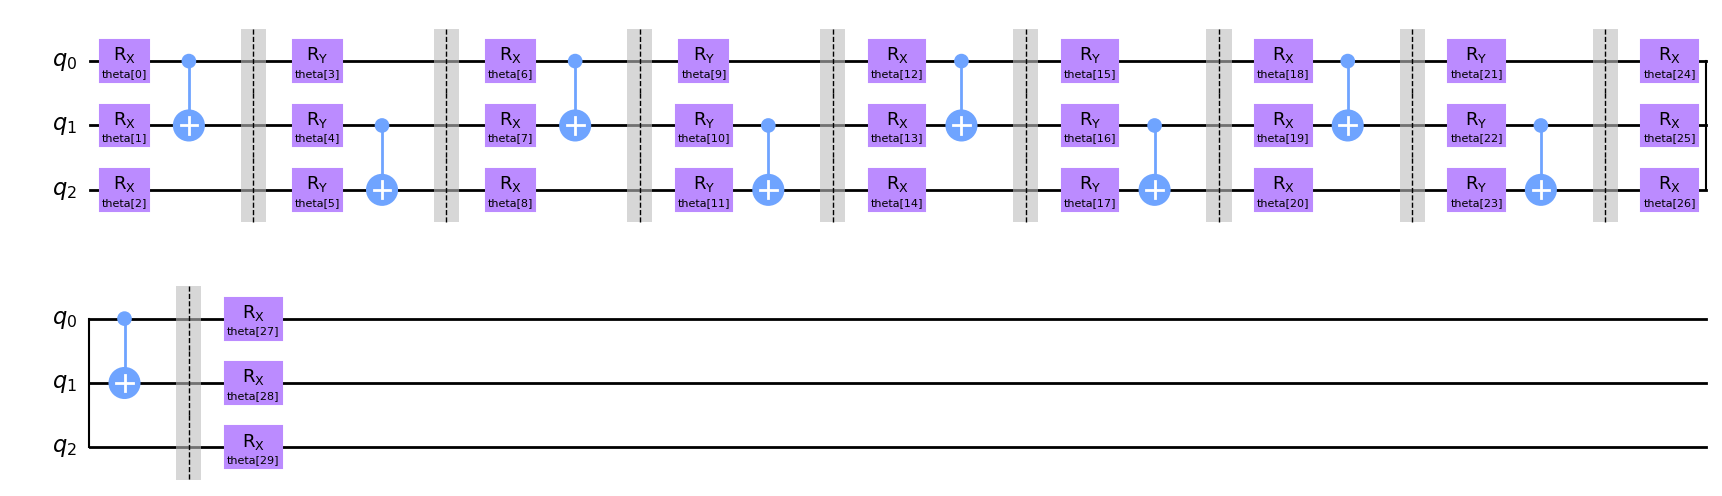

In [13]:
ansatz.draw(output="mpl", style="clifford")

In [14]:
ansatz_isa_list = get_isa_circ_list_for_bases(ansatz, basis_list, pm)

In [15]:
def get_ansatz_output(ansatz_isa_list, parameters, basis_list, shots, param_placeholder=param_vec):
    circ_run_list = [circ.assign_parameters({param_placeholder:parameters}) for circ in ansatz_isa_list]
    return measure_isa_circ_list_fs(isa_circ_list=circ_run_list, basis_list=basis_list, shots=shots)

In [16]:
def string_to_arr(string):
    """Convert a bit string of 0 and 1 to an array of 0 and 1"""
    return [int(c) for c in string]

def kernel(arr, bw_list, coeff_list=None):
    assert np.ndim(arr) == 2
    assert len(bw_list) == len(coeff_list)

    n_datapoints, n_qubits = arr.shape

    diff_mat = np.expand_dims(arr, axis=0) - np.expand_dims(arr, axis=1)
    diff2 = np.sum(diff_mat**2, axis=-1) 

    result_mat = np.zeros((n_datapoints,n_datapoints))
    for (bw, coeff) in zip(bw_list, coeff_list):
        result_mat += coeff * np.exp(-0.5 * diff2 / bw)
    
    return result_mat

def mmd_for_one_basis(dict1, dict2, bw_list, coeff_list=None):
    outcomes1 = dict1.keys()
    outcomes2 = dict2.keys()
    outcome_strings = list(set(outcomes1).union(set(outcomes2)))
    outcome_arr = np.array([string_to_arr(string) for string in outcome_strings])

    kernel_matrix = kernel(outcome_arr, bw_list, coeff_list)

    vec_1 = np.array([dict1.get(string, 0) for string in outcome_strings])
    vec_2 = np.array([dict2.get(string, 0) for string in outcome_strings])

    vec_1 = vec_1 / np.sum(vec_1)
    vec_2 = vec_2 / np.sum(vec_2)

    return vec_1 @ kernel_matrix @ vec_1 + vec_2 @ kernel_matrix @ vec_2 - 2 * vec_1 @ kernel_matrix @ vec_2



def mmd_loss(true_data, test_data, bw_list, coeff_list=None):
    loss = 0.

    if coeff_list is None:
        coeff_list = np.ones(len(bw_list))
    elif np.ndim(coeff_list) == 0:
        coeff_list = np.ones(len(bw_list)) * coeff_list
    else:
        assert len(bw_list) == len(coeff_list)

    for basis in true_data:
        loss += mmd_for_one_basis(true_data[basis], test_data[basis], bw_list, coeff_list)
        
    return loss / len(true_data)
    

In [17]:
global loss_values
global thetas

loss_values = []
thetas = []

In [18]:
def compute_loss_mmd(theta_vector, ansatz_isa_list,  basis_list, true_data, total_shots, param_placeholder=param_vec, \
        have_checkpoints=have_checkpoints, checkpoint_path=checkpoint_path, bw_list = bw_list, bw_coeff_list = bw_coeff_list):
    # theta = np.reshape(theta_vector, (circ_depth, num_qbits))
    # tempcirc = construct_variational_circ(theta=theta)
    test_data = get_ansatz_output(ansatz_isa_list=ansatz_isa_list, parameters=theta_vector, basis_list=basis_list, \
        shots=total_shots, param_placeholder=param_placeholder)
    # test_data = measure_circ_for_all_basis(qc = tempcirc, basis_list=basis_list, simulator=simulator)
    loss = mmd_loss(true_data, test_data, bw_list, coeff_list=bw_coeff_list)

    global loss_values
    global thetas 
    loss_values.append(loss)
    thetas.append(theta_vector)

    num_iter = len(loss_values)

    print(f"Iteration {num_iter:5}; current loss is {loss}")

    if have_checkpoints:
        # save checkpoints in case the connection to qpu breaks
        # useful for running on real qpu, but not necessary for local simulation
        np.save(os.path.join(checkpoint_path, f"theta_iter{num_iter}.npy"), thetas)
    
    return loss

In [19]:
def compute_loss_filled(theta_vector):
    return compute_loss_mmd(theta_vector, ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec)

In [20]:
def callback(nev, x, fx, a, flag):
    print(f"Number of call {nev:5}; current loss is {fx}")

In [21]:
%%time

theta = initialize_theta_random(circ_depth=depth, num_qbits = n_qubits)
theta_vector = np.reshape(theta, theta.size)
circ_depth, num_qbits = theta.shape

# spsa = SPSA(maxiter=300, callback=callback)
spsa = SPSA(maxiter=300)

# c=0.1258
# A=0.3186
# a1=0.4739
# alpha=0.6374
# gamma=0.06059
# (lr, p) = spsa.calibrate(compute_loss_filled, theta_vector, c=c, stability_constant = A, target_magnitude=a1, alpha=alpha, gamma=gamma)
# spsa.learning_rate = lr
# spsa.perturbation = p

# args = (ansatz_isa_list, basis_list, GHZ_measurement, shots, param_vec)

# results = opt.minimize(compute_kl_loss, theta_vector, args = args, method = "Powell", options={"maxiter":max_iter})

results = spsa.minimize(compute_loss_filled, theta_vector)


Iteration     1; current loss is 1.6313461094728234
Iteration     2; current loss is 1.7008827340276667
Iteration     3; current loss is 1.463002906323676
Iteration     4; current loss is 1.659998972409783
Iteration     5; current loss is 1.701373822493514
Iteration     6; current loss is 1.8077578785531803
Iteration     7; current loss is 1.8871988622451918
Iteration     8; current loss is 1.586444347005043
Iteration     9; current loss is 1.6032664397710195
Iteration    10; current loss is 1.905483554354467
Iteration    11; current loss is 1.6471597420838118
Iteration    12; current loss is 1.8855283056630197
Iteration    13; current loss is 1.8730668788943858
Iteration    14; current loss is 1.835917820950809
Iteration    15; current loss is 1.9790739049790906
Iteration    16; current loss is 1.7899679493681138
Iteration    17; current loss is 1.964129665061881
Iteration    18; current loss is 1.7728192166089376
Iteration    19; current loss is 1.9302097188427547
Iteration    20; cu

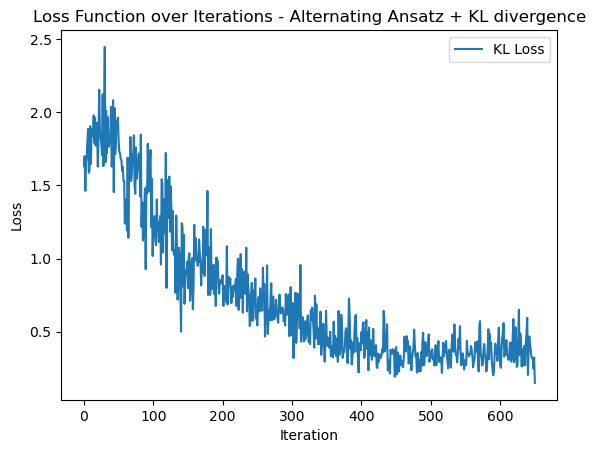

In [22]:
fig, ax = plt.subplots()
ax.plot(loss_values, label=f"KL Loss")
# plt.ylim(0, 30)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title(f"Loss Function over Iterations - Alternating Ansatz + KL divergence")
ax.legend()

# fig.savefig("loss_curve.png")

In [23]:

def simulate_circ(circ):
    """
    Generates our estimate state |phi> via simulation
    :param circ: qiskit.QuantumCircuit object, the variational quantum circuit
    :return: qiskit.Statevector object, represents our estimated quantum state |phi>
    """

    simulator = AerSimulator(method='statevector')
    circ.save_statevector() 
    job = simulator.run(circ)
    result = job.result()
    circ_statevect = Statevector(result.get_statevector(circ))
    
    return circ_statevect

def compute_fidelity(psi, phi):
    """
    Compute the fidelity (a measure of similarity) between the two states
    :param psi: qiskit.Statevector, our target state |psi>
    :param phi: qiskit.Statevector, our estimated state |phi>
    :return: float, fidelity
    """

    fidelity = qiskit.quantum_info.state_fidelity(psi, phi)
    print(f"psi: {psi}, phi: {phi}")
    # fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # plot_bloch_multivector(psi)
    # axes[0].set_title("psi")
    # plot_bloch_multivector(phi)
    # axes[1].set_title("phi")
    return fidelity



ghz_state = Statevector.from_instruction(ghz_circ)
ansatz_state = Statevector.from_instruction(ansatz.assign_parameters({param_vec : results.x}))

final_fidelity = qiskit.quantum_info.state_fidelity(ghz_state, ansatz_state)

In [24]:
print(f"ghz state: {ghz_state}\nansatz: {ansatz_state}")

ghz state: Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
ansatz: Statevector([ 0.51047363-0.50007067j,  0.03572149-0.01855131j,
             -0.01499308-0.03909721j, -0.0083259 +0.01039536j,
              0.0019566 +0.00590434j, -0.01014577-0.02292329j,
              0.03448712+0.05258005j,  0.48758814-0.49338802j],
            dims=(2, 2, 2))


In [25]:
print(final_fidelity)

0.9915437274726202


In [26]:
print(results.x)

[ 0.9370474  -2.35703201  0.14030585 -2.17460797  0.66522445  0.40974724
 -0.93125306 -0.28994214 -1.6251211   2.54445567 -1.40885885  0.62876267
  1.98272774 -1.00769319 -1.57738688 -0.20381367  0.43085977  1.54119575
 -0.76332766  0.06253129  2.12285259 -2.15271122  2.84356086 -0.44352836
 -0.06432571  0.55508878  0.61986258  0.32994327 -0.06357771  0.39483049]


In [27]:
np.save(f"saved/params_training_s{trial}.npy", thetas)
np.save(f"saved/loss_training_s{trial}.npy", loss_values)
np.save(f"saved/final_theta_s{trial}.npy", results.x)
np.save(f"saved/fidelity_s{trial}.npy", final_fidelity)